In [3]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from shutil import copy2, move
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [1]:
!wget -O images.zip "https://zenodo.org/records/15298010/files/images.zip?download=1"

--2025-11-09 13:10:57--  https://zenodo.org/records/15298010/files/images.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148063776 (1.1G) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>]   1.07G   517KB/s    in 36m 58s 

2025-11-09 13:47:56 (506 KB/s) - ‘images.zip’ saved [1148063776/1148063776]



In [2]:
!wget -O mask.zip https://zenodo.org/records/15298010/files/masks.zip?download=1

--2025-11-09 13:47:56--  https://zenodo.org/records/15298010/files/masks.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.43.153, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28276974 (27M) [application/octet-stream]
Saving to: ‘mask.zip’

mask.zip            100%[===================>]  26.97M  3.14MB/s    in 18s     

2025-11-09 13:48:15 (1.46 MB/s) - ‘mask.zip’ saved [28276974/28276974]



In [4]:
!mkdir -p /content/oil_spill_dataset/images

In [5]:
!mkdir -p /content/oil_spill_dataset/mask

In [6]:
!unzip mask.zip -d /content/oil_spill_dataset/mask


Streaming output truncated to the last 5000 lines.
  inflating: /content/oil_spill_dataset/mask/masks/train/sentinel_555.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._sentinel_555.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/sentinel_2145.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._sentinel_2145.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/palsar_2465.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._palsar_2465.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/palsar_2303.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._palsar_2303.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/sentinel_2623.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/masks/train/._sentinel_2623.png  
  inflating: /content/oil_spill_dataset/mask/masks/train/sentinel_2637.png  
  inflating: /content/oil_spill_dataset/mask/__MACOSX/mas

In [8]:
!unzip images.zip -d /content/oil_spill_dataset/images


Streaming output truncated to the last 5000 lines.
  inflating: /content/oil_spill_dataset/images/images/train/sentinel_555.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._sentinel_555.png  
  inflating: /content/oil_spill_dataset/images/images/train/sentinel_2145.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._sentinel_2145.png  
  inflating: /content/oil_spill_dataset/images/images/train/palsar_2465.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._palsar_2465.png  
  inflating: /content/oil_spill_dataset/images/images/train/palsar_2303.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._palsar_2303.png  
  inflating: /content/oil_spill_dataset/images/images/train/sentinel_2623.png  
  inflating: /content/oil_spill_dataset/images/__MACOSX/images/train/._sentinel_2623.png  
  inflating: /content/oil_spill_dataset/images/images/train/sentinel_2637.png  
  inflating: /content/oi

In [10]:
base_dir = "/content/oil_spill_dataset"
for root, dirs, files in os.walk(base_dir):
    print(root, len(files))

/content/oil_spill_dataset 0
/content/oil_spill_dataset/mask 0
/content/oil_spill_dataset/mask/__MACOSX 1
/content/oil_spill_dataset/mask/__MACOSX/masks 3
/content/oil_spill_dataset/mask/__MACOSX/masks/val 1615
/content/oil_spill_dataset/mask/__MACOSX/masks/train 6455
/content/oil_spill_dataset/mask/masks 1
/content/oil_spill_dataset/mask/masks/val 1615
/content/oil_spill_dataset/mask/masks/train 6455
/content/oil_spill_dataset/images 0
/content/oil_spill_dataset/images/__MACOSX 1
/content/oil_spill_dataset/images/__MACOSX/images 3
/content/oil_spill_dataset/images/__MACOSX/images/val 1615
/content/oil_spill_dataset/images/__MACOSX/images/train 6455
/content/oil_spill_dataset/images/images 1
/content/oil_spill_dataset/images/images/val 1615
/content/oil_spill_dataset/images/images/train 6455


In [11]:
!rm -rf /content/oil_spill_dataset/images/__MACOSX
!rm -rf /content/oil_spill_dataset/mask/__MACOSX


In [12]:
base_dir = "/content/oil_spill_dataset"
for root, dirs, files in os.walk(base_dir):
    print(root, len(files))

/content/oil_spill_dataset 0
/content/oil_spill_dataset/mask 0
/content/oil_spill_dataset/mask/masks 1
/content/oil_spill_dataset/mask/masks/val 1615
/content/oil_spill_dataset/mask/masks/train 6455
/content/oil_spill_dataset/images 0
/content/oil_spill_dataset/images/images 1
/content/oil_spill_dataset/images/images/val 1615
/content/oil_spill_dataset/images/images/train 6455


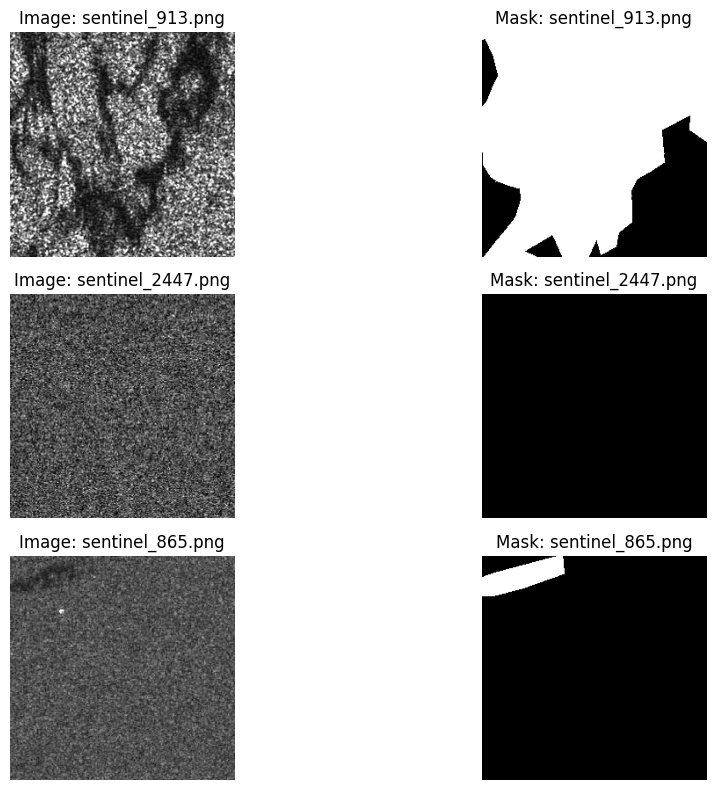

In [13]:
# Define paths
image_dir = "/content/oil_spill_dataset/images/images/train"
mask_dir = "/content/oil_spill_dataset/mask/masks/train"

# Get list of image filenames
image_files = os.listdir(image_dir)

# Pick 3 random images
sample_files = random.sample(image_files, 3)

# Plot each image with its mask
plt.figure(figsize=(12, 8))

for i, file_name in enumerate(sample_files):
    # Load image and mask
    img_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)

    # Plot image
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(image)
    plt.title(f"Image: {file_name}")
    plt.axis("off")

    # Plot mask
    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask: {file_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()


IoU Score: 0.2149


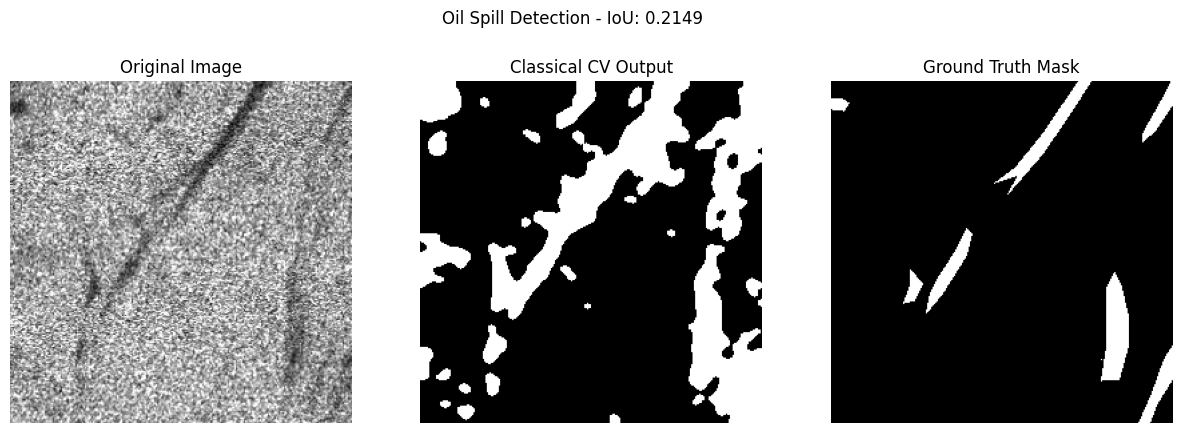

In [16]:
## Using classical CV approach

# --- Classical segmentation function ---
def simple_detect(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    eq = cv2.equalizeHist(img)
    blur = cv2.GaussianBlur(eq, (21,21), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)
    return cv2.bitwise_not(clean)

# --- Compute IoU ---
def compute_iou(pred_mask, true_mask):
    pred = pred_mask.astype(bool)
    true = true_mask.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    iou = intersection / union if union != 0 else 0
    return iou

# --- Example paths (change these to your actual dataset paths) ---
img_path = '/content/oil_spill_dataset/images/images/train/palsar_1225.png'
mask_path = '/content/oil_spill_dataset/mask/masks/train/palsar_1225.png'

# --- Run detection ---
pred_mask = simple_detect(img_path)
true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# --- Compute IoU ---
iou_score = compute_iou(pred_mask, true_mask)
print(f"IoU Score: {iou_score:.4f}")

# --- Plot results ---
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title('Classical CV Output')
axs[1].axis('off')

axs[2].imshow(true_mask, cmap='gray')
axs[2].set_title('Ground Truth Mask')
axs[2].axis('off')

plt.suptitle(f"Oil Spill Detection - IoU: {iou_score:.4f}")
plt.show()


In [15]:
print("For the computer vision baseleine method")

def simple_detect(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    eq = cv2.equalizeHist(img)
    blur = cv2.GaussianBlur(eq, (21, 21), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Invert so oil is white
    return cv2.bitwise_not(clean)


# --- Compute IoU ---
def compute_iou(pred_mask, true_mask):
    pred = pred_mask.astype(bool)
    true = true_mask.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / union if union != 0 else 0


# --- Paths ---
val_img_dir = "/content/oil_spill_dataset/images/images/val"
val_mask_dir = "/content/oil_spill_dataset/mask/masks/val"

# --- Loop through all validation images ---
iou_scores = []
file_names = sorted(os.listdir(val_img_dir))

for fname in tqdm(file_names, desc="Evaluating Validation Set"):
    img_path = os.path.join(val_img_dir, fname)
    mask_path = os.path.join(val_mask_dir, fname)

    if not os.path.exists(mask_path):
        continue  # Skip if mask missing

    pred_mask = simple_detect(img_path)
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Ensure same size
    if pred_mask.shape != true_mask.shape:
        true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]))

    iou = compute_iou(pred_mask, true_mask)
    iou_scores.append(iou)

# --- Mean IoU ---
mean_iou = np.mean(iou_scores)
print(f"\n✅ Mean IoU on Validation Set: {mean_iou:.4f}")

For the computer vision baseleine method


Evaluating Validation Set: 100%|██████████| 1615/1615 [00:07<00:00, 205.07it/s]


✅ Mean IoU on Validation Set: 0.5304


In [17]:
## Prepare data for training

# paths
BASE = "/content/oil_spill_dataset"
IMG_SRC = os.path.join(BASE, "images", "images", "train")
MASK_SRC = os.path.join(BASE, "mask", "masks", "train")

OUT = "/content/oil_spill_dataset_prepped"
os.makedirs(OUT, exist_ok=True)

for split in ["train","val","test"]:
    os.makedirs(os.path.join(OUT, "images", split), exist_ok=True)
    os.makedirs(os.path.join(OUT, "masks", split), exist_ok=True)

# list all image files (assuming masks have same filenames)
all_files = sorted([f for f in os.listdir(IMG_SRC) if f.lower().endswith(('.png','.jpg','.jpeg'))])
print("Total train images:", len(all_files))

# split - use 20% of the original train as validation; keep provided val as test later
train_files, val_temp = train_test_split(all_files, test_size=0.20, random_state=42)

# copy splits
for f in train_files:
    copy2(os.path.join(IMG_SRC, f), os.path.join(OUT, "images", "train", f))
    copy2(os.path.join(MASK_SRC, f), os.path.join(OUT, "masks", "train", f))

for f in val_temp:
    copy2(os.path.join(IMG_SRC, f), os.path.join(OUT, "images", "val", f))
    copy2(os.path.join(MASK_SRC, f), os.path.join(OUT, "masks", "val", f))

# copy the provided validation set as test (images/images/val and mask/masks/val)
PROVIDED_VAL_IMG = os.path.join(BASE, "images", "images", "val")
PROVIDED_VAL_MASK = os.path.join(BASE, "mask", "masks", "val")
provided_val_files = sorted([f for f in os.listdir(PROVIDED_VAL_IMG) if f.lower().endswith(('.png','.jpg'))])
for f in provided_val_files:
    copy2(os.path.join(PROVIDED_VAL_IMG, f), os.path.join(OUT, "images", "test", f))
    copy2(os.path.join(PROVIDED_VAL_MASK, f), os.path.join(OUT, "masks", "test", f))

print("Prepared folders under:", OUT)


Total train images: 6455
Prepared folders under: /content/oil_spill_dataset_prepped


In [18]:
## Making sure masks are 0/1

mask_dir = os.path.join(OUT, "masks", "train")
for fname in os.listdir(mask_dir):
    p = os.path.join(mask_dir, fname)
    m = Image.open(p).convert("L")
    arr = np.array(m)
    # threshold -> 0 or 255; assume white (255) is oil
    bin_arr = (arr > 127).astype('uint8') * 255
    Image.fromarray(bin_arr).save(p)

In [19]:
## creating segdataset class for image data

class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, files, size=128, augment=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.files = files
        self.size = size
        self.augment = augment
        self.tf = T.Compose([
            T.Resize((size,size)),
            T.ToTensor(),
            # images are grayscale: ToTensor -> shape (1, H, W)
            T.Normalize([0.5], [0.5])  # single channel norm
        ])
        self.tf_mask = T.Compose([
            T.Resize((size,size)),
            T.ToTensor(),  # mask -> float [0,1]
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        img = Image.open(os.path.join(self.img_dir, f)).convert('L')  # 'L' for grayscale
        mask = Image.open(os.path.join(self.mask_dir, f)).convert('L')
        img = self.tf(img)
        mask = self.tf_mask(mask)
        # ensure binary 0/1
        mask = (mask > 0.5).float()
        return img, mask


In [20]:
train_files = sorted(os.listdir("/content/oil_spill_dataset_prepped/images/train"))
val_files = sorted(os.listdir("/content/oil_spill_dataset_prepped/images/val"))

train_ds = SegDataset("/content/oil_spill_dataset_prepped/images/train",
                      "/content/oil_spill_dataset_prepped/masks/train",
                      train_files, size=128)
val_ds = SegDataset("/content/oil_spill_dataset_prepped/images/val",
                    "/content/oil_spill_dataset_prepped/masks/val",
                    val_files, size=128)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)


In [21]:
## Define Tiny Unet model architecture
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

# 3 encoder 3 decoder unet architecture
class TinyUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_c=16):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base_c)
        self.enc2 = DoubleConv(base_c, base_c*2)
        self.enc3 = DoubleConv(base_c*2, base_c*4)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base_c*4, base_c*8)

        self.up3 = nn.ConvTranspose2d(base_c*8, base_c*4, 2, stride=2)
        self.dec3 = DoubleConv(base_c*8, base_c*4)
        self.up2 = nn.ConvTranspose2d(base_c*4, base_c*2, 2, stride=2)
        self.dec2 = DoubleConv(base_c*4, base_c*2)
        self.up1 = nn.ConvTranspose2d(base_c*2, base_c, 2, stride=2)
        self.dec1 = DoubleConv(base_c*2, base_c)

        self.final = nn.Conv2d(base_c, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

# 2 encoder and decoder unet architecture
class TinyUNet2Layer(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_c=16):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_ch, base_c)
        self.enc2 = DoubleConv(base_c, base_c * 2)
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_c * 2, base_c * 4)

        # Decoder
        self.up2 = nn.ConvTranspose2d(base_c * 4, base_c * 2, 2, stride=2)
        self.dec2 = DoubleConv(base_c * 4, base_c * 2)
        self.up1 = nn.ConvTranspose2d(base_c * 2, base_c, 2, stride=2)
        self.dec1 = DoubleConv(base_c * 2, base_c)

        # Final output layer
        self.final = nn.Conv2d(base_c, out_ch, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))

        # Bottleneck
        b = self.bottleneck(self.pool(e2))

        # Decoder
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Output
        return self.final(d1)


In [22]:
def iou_score(pred, target, eps=1e-6):
    # pred, target are binary tensors (B,1,H,W)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=[1,2,3])
    union = ((pred + target) > 0).float().sum(dim=[1,2,3])
    return ((inter + eps) / (union + eps)).mean().item()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TinyUNet2Layer(in_ch=1, out_ch=1, base_c=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

print("For the 2 layer tiny Unet:")
# training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(preds)
            val_iou += iou_score(probs, masks) * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    val_iou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | val_iou {val_iou:.4f}")


For the 2 layer tiny Unet:
Epoch 1/15 | train_loss 0.3710 | val_loss 0.2871 | val_iou 0.5563
Epoch 2/15 | train_loss 0.2552 | val_loss 0.2405 | val_iou 0.5749
Epoch 3/15 | train_loss 0.2353 | val_loss 0.2114 | val_iou 0.6353
Epoch 4/15 | train_loss 0.2266 | val_loss 0.2145 | val_iou 0.6445
Epoch 5/15 | train_loss 0.2253 | val_loss 0.2046 | val_iou 0.6432
Epoch 6/15 | train_loss 0.2180 | val_loss 0.2038 | val_iou 0.6533
Epoch 7/15 | train_loss 0.2131 | val_loss 0.2029 | val_iou 0.6348
Epoch 8/15 | train_loss 0.2200 | val_loss 0.1986 | val_iou 0.6511
Epoch 9/15 | train_loss 0.2141 | val_loss 0.2036 | val_iou 0.6495
Epoch 10/15 | train_loss 0.2130 | val_loss 0.1910 | val_iou 0.6600
Epoch 11/15 | train_loss 0.2110 | val_loss 0.1953 | val_iou 0.6604
Epoch 12/15 | train_loss 0.2093 | val_loss 0.2015 | val_iou 0.6557
Epoch 13/15 | train_loss 0.2061 | val_loss 0.1885 | val_iou 0.6666
Epoch 14/15 | train_loss 0.2064 | val_loss 0.1940 | val_iou 0.6583
Epoch 15/15 | train_loss 0.2043 | val_loss 0

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TinyUNet(in_ch=1, out_ch=1, base_c=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

print("For the 3 layer tiny Unet:")
# training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(preds)
            val_iou += iou_score(probs, masks) * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    val_iou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | val_iou {val_iou:.4f}")

For the 3 layer tiny Unet:
Epoch 1/15 | train_loss 0.3322 | val_loss 0.3063 | val_iou 0.5774
Epoch 2/15 | train_loss 0.2445 | val_loss 0.2142 | val_iou 0.6258
Epoch 3/15 | train_loss 0.2223 | val_loss 0.2595 | val_iou 0.6254
Epoch 4/15 | train_loss 0.2206 | val_loss 0.2079 | val_iou 0.6535
Epoch 5/15 | train_loss 0.2093 | val_loss 0.2991 | val_iou 0.5959
Epoch 6/15 | train_loss 0.2056 | val_loss 0.2297 | val_iou 0.6436
Epoch 7/15 | train_loss 0.1991 | val_loss 0.1885 | val_iou 0.6525
Epoch 8/15 | train_loss 0.1993 | val_loss 0.1826 | val_iou 0.6597
Epoch 9/15 | train_loss 0.1950 | val_loss 0.2131 | val_iou 0.6257
Epoch 10/15 | train_loss 0.1938 | val_loss 0.1805 | val_iou 0.6581
Epoch 11/15 | train_loss 0.1933 | val_loss 0.1805 | val_iou 0.6625
Epoch 12/15 | train_loss 0.1909 | val_loss 0.1731 | val_iou 0.6751
Epoch 13/15 | train_loss 0.1870 | val_loss 0.1947 | val_iou 0.6663
Epoch 14/15 | train_loss 0.1894 | val_loss 0.1730 | val_iou 0.6811
Epoch 15/15 | train_loss 0.1847 | val_loss 0

In [25]:
from torch.utils.data import ConcatDataset, DataLoader

# existing datasets
train_ds = SegDataset("/content/oil_spill_dataset_prepped/images/train",
                      "/content/oil_spill_dataset_prepped/masks/train",
                      sorted(os.listdir("/content/oil_spill_dataset_prepped/images/train")),
                      size=128)

val_ds = SegDataset("/content/oil_spill_dataset_prepped/images/val",
                    "/content/oil_spill_dataset_prepped/masks/val",
                    sorted(os.listdir("/content/oil_spill_dataset_prepped/images/val")),
                    size=128)

# combine them for final training
trainval_ds = ConcatDataset([train_ds, val_ds])

# new dataloader for final training
trainval_loader = DataLoader(trainval_ds, batch_size=16, shuffle=True, num_workers=2)


In [26]:
## the 2 layer unet would be chosen because there is really not much difference with the 3 layer unet and only 10 epochs would be used for final training

model = TinyUNet2Layer(in_ch=1, out_ch=1, base_c=16).to(device)
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()
    for imgs, masks in trainval_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.4246
Epoch 2/10, Loss: 0.3623
Epoch 3/10, Loss: 0.5383
Epoch 4/10, Loss: 0.3108
Epoch 5/10, Loss: 0.2576
Epoch 6/10, Loss: 0.2308
Epoch 7/10, Loss: 0.2028
Epoch 8/10, Loss: 0.3184
Epoch 9/10, Loss: 0.2295
Epoch 10/10, Loss: 0.2533


In [28]:
test_ds = SegDataset("/content/oil_spill_dataset_prepped/images/test",
                     "/content/oil_spill_dataset_prepped/masks/test",
                     sorted(os.listdir("/content/oil_spill_dataset_prepped/images/test")),
                     size=128)

test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)


In [29]:
from sklearn.metrics import jaccard_score
import numpy as np

model.eval()
ious = []
i = 0
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = torch.sigmoid(model(imgs)) > 0.5
        preds = preds.cpu().numpy().astype(np.uint8)
        masks = masks.cpu().numpy().astype(np.uint8)
        for p, m in zip(preds, masks):
            iou = jaccard_score(m.flatten(), p.flatten())
            ious.append(iou)
            i+=1
            if i % 10 == 0:
              print(iou)

print("Mean IoU on test set:", np.mean(ious))


0.24606780845858092
0.4895554365291912
0.8667305848513902


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5943293347873501
0.7334030318870883
0.8609970674486803
0.81335436382755


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.303951367781155
0.0
0.6609404823876454
0.5676167374166161
0.8915731952832902
0.6076099881093936
0.00639386189258312
0.6320422535211268


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.4776887871853547
0.34504540071061984
0.6367389060887513
0.4336870026525199


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics

0.0
0.7465641154961543
0.5743670886075949
0.5679886685552408


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0
0.31633986928104574
0.533796740172579
0.527086383601757
0.8586508753861998
0.7728028503562946
0.5473965287049399
0.7690782953419227


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.7014420509168595
0.0
0.9020828859780975
0.9726066897347174


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics

0.9383548261039468
0.9278384640847401
0.6686967113276492
0.5732838589981447
0.8070063694267516


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8
0.7824767684430116
0.765751530713016
0.8502146605183654


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.7720873786407767
0.912468438138752
0.817780580075662
0.6200187090739009


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.6289822385114181
0.9092896174863389
0.5328467153284672
0.7446969696969697
0.7867193285608491
0.7700501253132832
0.6306166718314223
0.7724739520232614
0.7921235175654509


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.7357409713574097
0.5379581151832461
0.5711297071129707
0.892244769545383


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8096838246525127
0.5371057513914657
0.662291169451074
0.8524844720496895
0.5555555555555556
0.9402691171644241
0.6294227188081937
0.5901339829476249


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics

0.0
0.9646017699115044
0.8795698924731182
0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics

0.6458026509572902
0.8482758620689655
0.5501510868505702
0.5129989015012816
0.1527840651878678
0.98431396484375
0.7540106951871658
0.5464562985224142
0.6618972951783614
0.32594506391079686
1.0
0.872226710583556


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.976361302016464
0.7686226282501757
0.423607626693427
0.7617290825560351


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5996730117949317
0.0
0.35157384987893464
0.5736738703339882
0.15666666666666668
0.9655221950869128
0.7518248175182481
0.8837733957219251
0.4996024383779486
0.48318462594371997
0.3582887700534759


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5837912087912088
0.7857932899102863
0.8837902948262016
0.5967987804878049
0.8944650637405196
0.0
0.9805424908188906
0.6860687022900763


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8609653725078699
0.5043140638481449
0.681025641025641


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.6187038819377607
0.856078860898138
0.5420824513657897
0.6297472373936238
0.4634864546525324
0.8261700095510984
0.8286384976525821
0.9852294921875
0.7878426698450537
0.8541497482540198
0.47434052757793765
0.7841409691629956
0.5963843185049766


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.7903013265395765
0.5105170902716915
0.7896222815719192
0.5570264765784114
0.6680512783785719
0.36354434322198864
0.8240053944706676
0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.11085238498447643
0.8612993883286494
0.6196059043717776
0.7534440127163546
0.5834123222748815
0.9388993513287298
0.5581298787576815
0.4533762057877814


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.9130028063610851
0.9927978515625
0.8760781422779211
0.9655498769638463
0.3078537910595209
0.6096131301289566
0.996518658767483
0.6233480176211453


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.9434883123555099
0.5637695637695638
0.4520096361100545
0.7568238213399504


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.3206672845227062
0.5936329588014981
0.5949825986078886
0.0
0.8146976744186046
0.16301779807843755
0.8333333333333334
0.0
0.5676369863013698
Mean IoU on test set: 0.6217271793273677


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics

In [31]:
## some of them have no oil so i will re calculate the mean iou
valid_ious = [iou for iou in ious if not iou==0]
print("Mean IoU (non-empty):", np.mean(valid_ious))

Mean IoU (non-empty): 0.6579878077416113


In [ ]:
model.train()

In [ ]:
torch.save(model, "oil_spill_unet_full.pth")